In [5]:
import kmodels as kmk
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_pickle('../data/SeparatedData.pkl')
df

,Time,Event,EPB,EPL,FPL,APL,ADD,FCU,FPB,OPP,Fx,Fy,Fz,Subject
0,0.000000,0,0.609387,0.425615,0.448714,0.759052,0.686264,0.066787,0.298815,0.601626,6.628719,-5.536619,-72.106877,bXa12
1,0.016722,0,0.621460,0.430126,0.451183,0.757899,0.687901,0.066837,0.298880,0.607359,6.438037,-5.549640,-73.115967,bXa12
2,0.033445,0,0.631084,0.435097,0.453312,0.755323,0.692222,0.066811,0.298609,0.613068,6.327789,-5.691851,-74.307988,bXa12
3,0.050167,0,0.637990,0.440523,0.455069,0.751424,0.698965,0.066699,0.298155,0.618620,6.591325,-5.942138,-74.517149,bXa12
4,0.066890,0,0.642083,0.446395,0.456437,0.746356,0.707680,0.066504,0.297653,0.623865,6.722019,-6.021124,-75.056662,bXa12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,4.932781,2,0.111433,0.079270,0.040960,0.024509,0.051543,0.116518,0.185874,0.143175,6.296023,-0.046129,-24.747921,zNu44
896,4.949503,2,0.105564,0.076230,0.039156,0.024097,0.051073,0.117729,0.175012,0.132562,4.910950,-0.154313,-20.377578,zNu44
897,4.966224,2,0.099609,0.073080,0.037808,0.023934,0.050917,0.116978,0.163997,0.121663,3.814453,-0.394626,-16.421894,zNu44
898,4.982945,2,0.093762,0.069941,0.036912,0.024011,0.051028,0.114628,0.153383,0.110998,2.864429,-0.684709,-13.006773,zNu44


In [7]:

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        # the window size represents how many samples to include in each window
        self.window_size = window_size
        # the stride represents how many samples to skip between windows
        self.stride = stride
        
        
        # make sure the df is ordered by subject
        self.df = self.df.sort_values(by=sort_column)
        self.df = self.df.reset_index(drop=True)
        self.subject_index = [i.values for i in self.df.groupby(sort_column).apply(lambda x: x.index)]
        self.subjects = list(self.df.groupby(sort_column).groups.keys())
        self.n_features = len(xcols)
        # sort the subject list index. self.subjects contains a list of indices for that belong to each subject. lets sort each list in ascending order
        # for each subject multiple trails are run. lets split them up and make a list of lists for each subject. The way we know a 
        # new event has started is when the time column resets to its minimum value.
        
        
        
        # split the subject index into events
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            # get the time column for the subject
            time = self.df.loc[subject]['Time'].values
            # get the indices where the time resets to its minimum value
            time_splits.append(np.where(time == time.min())[0])
            # split the subject index into events
            self.subject_events.append(np.split(subject, time_splits[-1]))
        # reorganize the dataframe in the order of subject_events
        self.df = pd.concat([pd.concat([self.df.loc[subject] for subject in event]) for event in self.subject_events])
        self.df = self.df.reset_index(drop=True)
        
        
        # remake subjects_events to be consistent with the new dataframe
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            # get the time column for the subject
            time = self.df.loc[subject]['Time'].values
            # get the indices where the time resets to its minimum value
            time_splits.append(np.where(time == time.min())[0])
            # split the subject index into events
            self.subject_events.append(np.split(subject, time_splits[-1]))
        # get rid of the empty lists in the list of lists
        self.subject_events = [[i for i in subject if len(i) > 0][0] for subject in self.subject_events]
        
        # for each subject we need to create a vector containig the indices for each window
        self.subject_windows = []
        for subject in self.subject_events:
            # get the number of windows for the subject
            n_windows = (len(subject) - self.window_size) // self.stride + 1
            # create a list of lists for the subject
            self.subject_windows.append([subject[i*self.stride:i*self.stride+self.window_size] for i in range(n_windows)])
        # get rid of the empty lists in the list of lists
        self.subject_windows = [[i for i in subject if len(i) > 0] for subject in self.subject_windows]
        # we should now be able to access the dataframe referencing the n-th frame of any subject using the __getitem__ method
        #self.subject_windows = np.concatenate(self.subject_windows)
        # reorganize self.subject_windows to be a single list of lists
        self.subject_windows = [i for subject in self.subject_windows for i in subject]
        # organize X for an LSTM model. The LSTM model expects the input to be in the shape (batch_size, seq_len, n_inputs)
        self.X = np.array([self.df.loc[window][self.xcols].values for window in self.subject_windows])
        self.X = self.X.reshape(-1, self.window_size, self.n_features)
        self.X = torch.from_numpy(self.X).float()
        
        # get the output
        self.Y = np.array([self.df.loc[window][self.ycols].values for window in self.subject_windows])
        self.Y  = torch.from_numpy(self.Y).float()
        self.Y = self.Y.view(self.X.shape[0], -1)
        self.X = self.X.to('cuda')
        self.Y = self.Y.to('cuda')
        return 
        
    
        
    def __getitem__(self, index):
        # the index is the index of the window in the subject_windows lis
        return self.df.loc[self.subject_windows[index]][self.xcols].values, self.df.loc[self.subject_windows[index]][self.ycols].values
    
    def __len__(self):
        return len(self.subject_index)

In [8]:
leave_out_df = df[df['Subject'] == 'RGr10']
train_df = df[df['Subject'] != 'RGr10']
train_data = Dataset_LSTM(train_df, window_size=100, stride=5)
test_data = Dataset_LSTM(leave_out_df, window_size=100, stride=5)

In [9]:
train_data.X.shape

torch.Size([861, 100, 8])

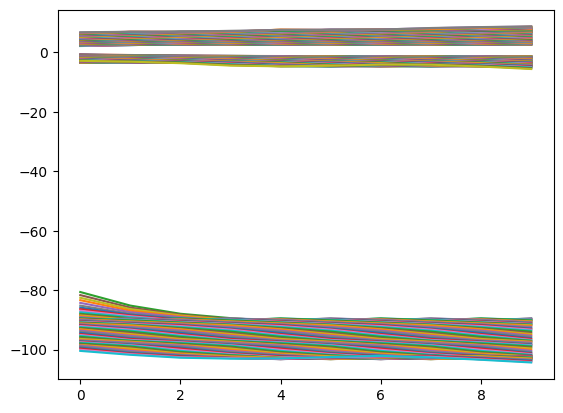

In [10]:
# plot the first 10 samples of data.Y
plt.plot(train_data.Y[:10].detach().cpu().numpy())

Text(0, 0.5, 'Force')

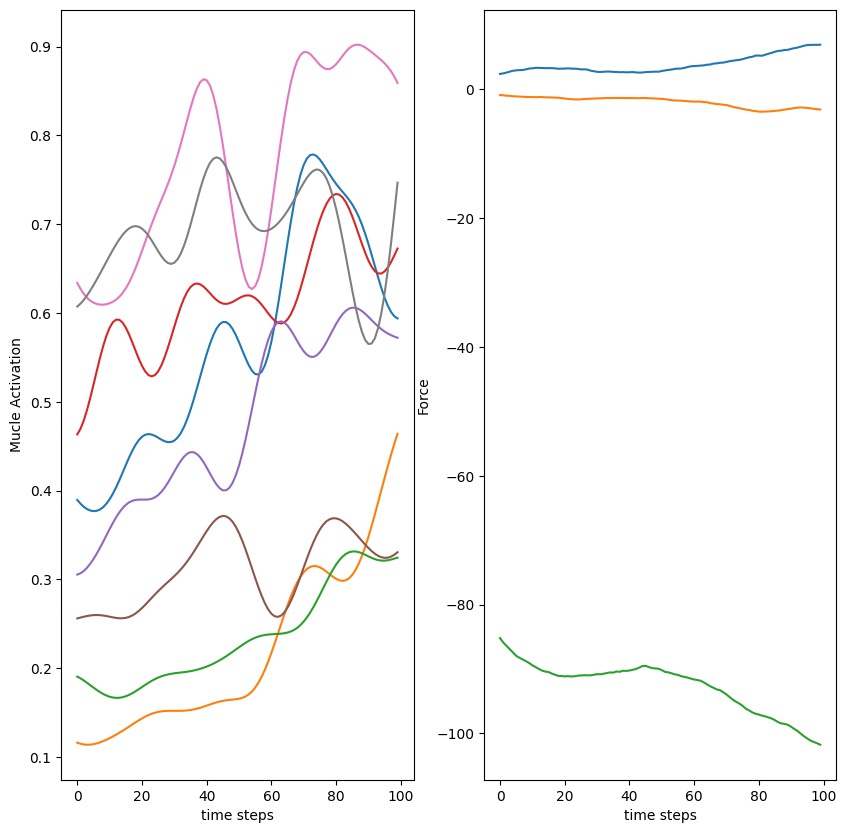

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(train_data[1][0])
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Mucle Activation')
ax[1].plot(train_data[1][1])
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')

In [51]:
# get relu from pytroch
from torch.nn import functional as F
class lstm(nn.Module):
    def __init__(self, n_inputs=8, hidden_size=30, n_outputs=300, n_linear_layers=1, 
                 layer_size=10, lstm_n_outputs=30):
        super().__init__()
        self.lstm = nn.LSTM(n_inputs, hidden_size, batch_first=True)
        self.fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for i in range(n_linear_layers)])
        self.layer_size = layer_size
        self.n_linear_layers = n_linear_layers 
        self.lstm_n_outputs = lstm_n_outputs
        self.output = nn.Linear(layer_size, n_outputs)
        
    def forward(self, x):
        rows = x.shape[0]
        x, _ = self.lstm(x)
        x = x.reshape(rows, -1)
        for i, fc in enumerate(self.fcs):
            if fc == self.fcs[0]:
                if x.shape[1] != int(fc.in_features):
                    try:    
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size)
                        x = F.relu(self.fcs[0](x))
                    except:
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size).to('cuda')
                        x = F.relu(self.fcs[0](x))
                else:
                    x = F.relu(fc(x))
            else:
                x = F.relu(fc(x))
        x = self.output(x)
        return x
    
 
                

In [66]:
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=300, bias=True)
)

In [67]:
# PASS A SAMPLE THROUGH TO FIX THE MODEL DIMENSIONS
model(train_data.X)
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3000, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=300, bias=True)
)

In [73]:
losses = kmk.run_Pytorch(model, train_data.X.reshape(-1, 100, 8), train_data.Y, n_epochs=200, batch_size=8, learning_rate=1e-3)

EPOCH :  0 , dt:  1.2757329940795898 seconds, losses : 26.069923400878906
EPOCH :  10 , dt:  11.64780068397522 seconds, losses : 29.855491638183594
EPOCH :  20 , dt:  11.113696813583374 seconds, losses : 18.463537216186523
EPOCH :  30 , dt:  10.984805822372437 seconds, losses : 18.755401611328125
EPOCH :  40 , dt:  10.993623971939087 seconds, losses : 10.380714416503906
EPOCH :  50 , dt:  10.918935060501099 seconds, losses : 7.543893337249756
EPOCH :  60 , dt:  10.806461811065674 seconds, losses : 16.92729949951172
EPOCH :  70 , dt:  10.910859107971191 seconds, losses : 11.472200393676758
EPOCH :  80 , dt:  11.162585496902466 seconds, losses : 7.417234897613525
EPOCH :  90 , dt:  11.29740595817566 seconds, losses : 3.89827036857605
EPOCH :  100 , dt:  11.194770097732544 seconds, losses : 3.31567645072937
EPOCH :  110 , dt:  10.965253591537476 seconds, losses : 5.925559997558594
EPOCH :  120 , dt:  11.100394248962402 seconds, losses : 4.082065582275391
EPOCH :  130 , dt:  10.76889300346

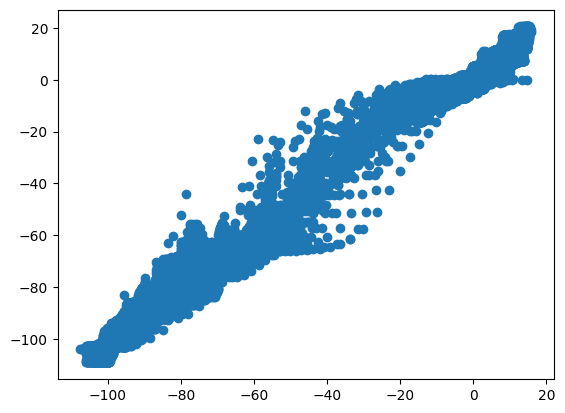

In [74]:
# parity plot
pred = model(train_data.X.to('cuda')).detach().cpu().numpy().reshape(-1,1)
y = train_data.Y.detach().cpu().numpy().reshape(-1,1)
plt.scatter(pred, y)

In [75]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(y, pred)
mae = mean_absolute_error(y, pred)
mse = mean_squared_error(y, pred)
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


r2:  0.9949176865911458 mae:  1.921937 mse:  6.943954


r2:  0.9053282442036561 mae:  8.347533 mse:  148.35071


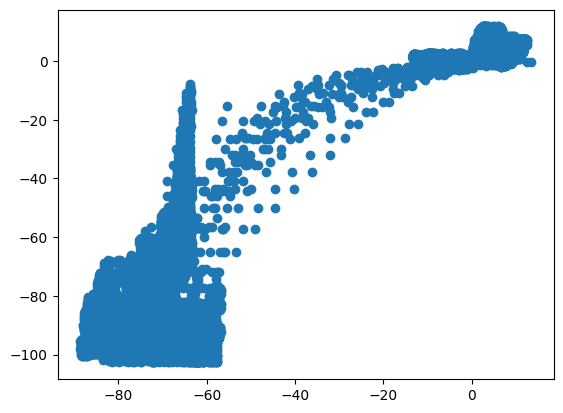

In [76]:
pred = model(test_data.X.to('cuda')).detach().cpu().numpy().reshape(-1,1)
y_test = test_data.Y.detach().cpu().numpy().reshape(-1,1)
plt.scatter(pred, y_test)
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


(100, 3)
[  6.339209   -1.3460156 -63.63179  ]


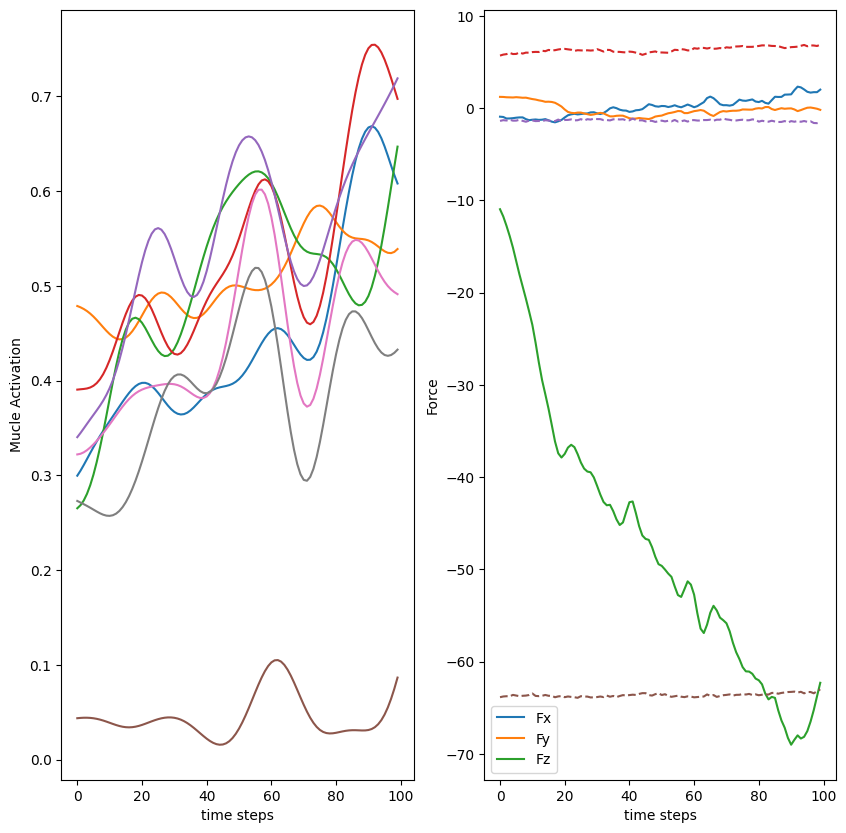

In [79]:
# plot a sample of the data
n = 1
x_plot = test_data.X[n].detach().cpu().numpy()
y_plot = test_data.Y[n].detach().cpu().numpy().reshape(-1, 3)
print(y_plot.shape)
y_labels = test_data.ycols
x_labels = test_data.xcols
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(x_plot)
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Mucle Activation')
ax[1].plot(y_plot)
    
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')
ax[1].legend(y_labels)
#plot the prediction of this sample
pred = model(test_data.X[0].to('cuda').unsqueeze(0)).detach().cpu().numpy().reshape(-1, 3)
ax[1].plot(pred, '--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)

r2:  0.9053282442036561 mae:  8.347533 mse:  148.35071
(100, 3)
[  6.339209   -1.3460156 -63.63179  ]


(array([[  5.6939096,  -1.3873984, -63.852867 ],
        [  5.8018627,  -1.3059115, -63.77641  ],
        [  5.8535557,  -1.3426093, -63.74855  ],
        [  5.9824452,  -1.2575644, -63.75676  ],
        [  5.863235 ,  -1.3581765, -63.60391  ],
        [  5.874857 ,  -1.3551538, -63.67487  ],
        [  6.035096 ,  -1.2630349, -63.742485 ],
        [  5.910813 ,  -1.3818401, -63.700916 ],
        [  6.015931 ,  -1.4755964, -63.67835  ],
        [  6.0081387,  -1.3590041, -63.61643  ],
        [  6.074861 ,  -1.340262 , -63.457085 ],
        [  6.094551 ,  -1.4054136, -63.714714 ],
        [  6.086264 ,  -1.3929138, -63.737778 ],
        [  6.222884 ,  -1.4170864, -63.702576 ],
        [  6.1709127,  -1.3129642, -63.611935 ],
        [  6.3091884,  -1.3478591, -63.699394 ],
        [  6.256549 ,  -1.4025521, -63.707596 ],
        [  6.280334 ,  -1.4042007, -63.85825  ],
        [  6.3572483,  -1.2378179, -63.767445 ],
        [  6.4100533,  -1.4205711, -63.731556 ],
        [  6.4225106

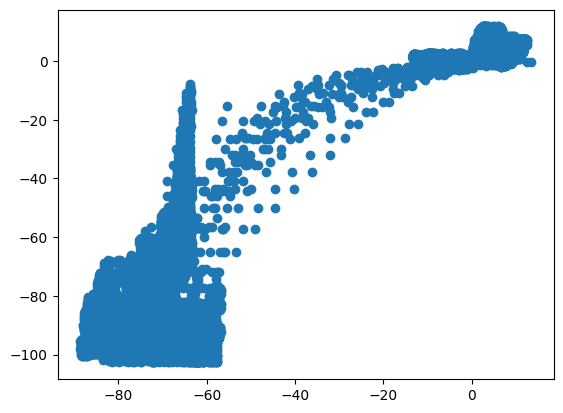

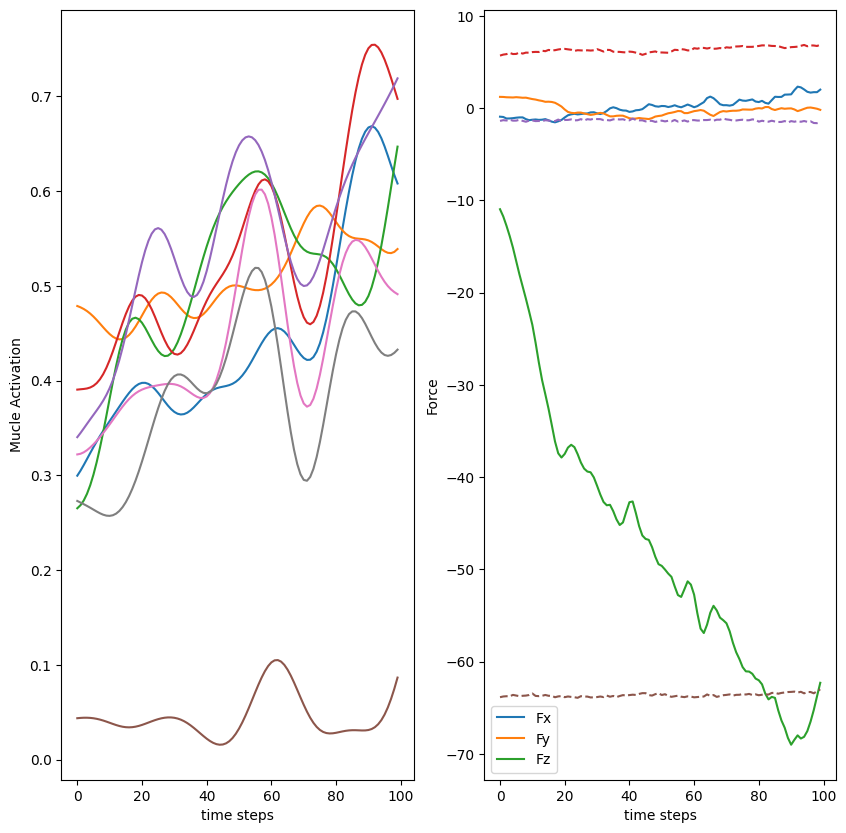

In [82]:
# test
plot_lstm_prediction(leave_out_df['Subject'].unique()[0])
